In [3]:
import numpy as np
import matplotlib.pyplot as plt

def computeH(im1_pts, im2_pts):
    n = len(im1_pts)
    A = np.zeros((2 * n, 8))
    b = np.zeros((2 * n, 1))

    for i in range(n):
        x, y = im1_pts[i]
        xp, yp = im2_pts[i]
        A[2*i]   = [x, y, 1, 0, 0, 0, -x*xp, -y*xp]
        A[2*i+1] = [0, 0, 0, x, y, 1, -x*yp, -y*yp]
        b[2*i]   = xp
        b[2*i+1] = yp

    # Solve Ah = b via least squares
    h, _, _, _ = np.linalg.lstsq(A, b, rcond=None)

    h = np.append(h, 1)
    H = h.reshape(3, 3)
    return H

Recovered Homography Matrix:
[[ 4.90792521e-01 -3.03338445e-01  1.61928810e+02]
 [-9.46260426e-02  4.84863462e-01  2.56664447e+02]
 [-1.41222136e-04 -2.10643213e-04  1.00000000e+00]]


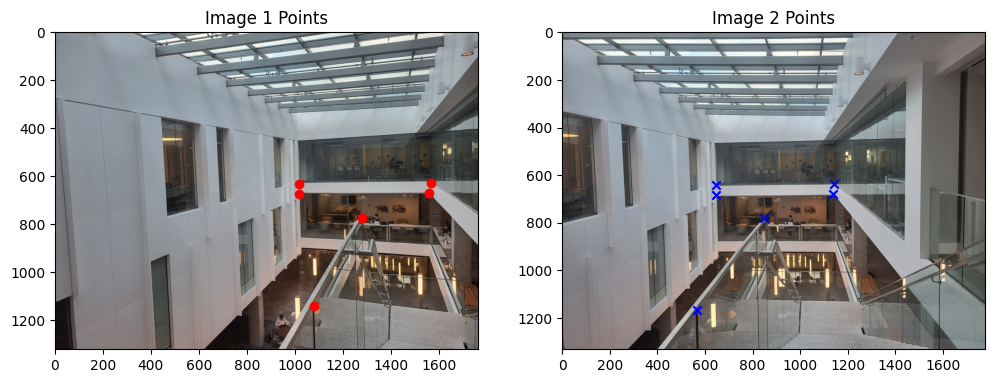

In [4]:
#  Deliverables: Implement computeH(im1_pts, im2_pts) function. Show your correspondences visualized on the images, system of equations, and recovered homography matrix. 
import json
from utils import show_image

with open("data/bair53_bair52.json") as f:
    data = json.load(f)

im1_name = data["im1_name"]
im2_name = data["im2_name"]
im1Points = np.array(data["im1Points"])
im2Points = np.array(data["im2Points"])

im1 = plt.imread(f"data/{im1_name}.jpg")
im2 = plt.imread(f"data/{im2_name}.jpg")
H = computeH(im1Points, im2Points)

print("Recovered Homography Matrix:")
print(H)


def visualize_correspondences(im1, im2, im1_pts, im2_pts):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(im1)
    axes[0].scatter(im1_pts[:, 0], im1_pts[:, 1], c='r', marker='o')
    axes[0].set_title('Image 1 Points')

    axes[1].imshow(im2)
    axes[1].scatter(im2_pts[:, 0], im2_pts[:, 1], c='b', marker='x')
    axes[1].set_title('Image 2 Points')

    plt.show()
    return fig

fig = visualize_correspondences(im1, im2, im1Points, im2Points)
fig.savefig("out/correspondences.png")

In [5]:
import numpy as np

def warpImageNearestNeighbor(im, H, output_shape=None):
    Hinv = np.linalg.inv(H)
    h, w = im.shape[:2]
    
    if output_shape is None:
        output_shape = (h, w)
    out_h, out_w = output_shape
    imwarped = np.zeros_like(im[:out_h, :out_w])

    ys, xs = np.indices((out_h, out_w))
    homog_pts = np.stack([xs.ravel(), ys.ravel(), np.ones(xs.size)])
    src = Hinv @ homog_pts
    src /= src[2, :]  # normalize

    x_src, y_src = src[0, :], src[1, :]

    x_src_round = np.round(x_src).astype(int)
    y_src_round = np.round(y_src).astype(int)

    valid = (x_src_round >= 0) & (x_src_round < w) & (y_src_round >= 0) & (y_src_round < h)
    
    imwarped[ys.ravel()[valid], xs.ravel()[valid]] = im[y_src_round[valid], x_src_round[valid]]
    return imwarped

def warpImageBilinear(im, H, output_shape=None, fill=0):
    h, w = im.shape[:2]
    if output_shape is None:
        out_h, out_w = h, w
    else:
        out_h, out_w = output_shape

    Hinv = np.linalg.inv(H)
    xs = np.arange(out_w)
    ys = np.arange(out_h)
    xs_grid, ys_grid = np.meshgrid(xs, ys, indexing='xy')
    pts = np.stack([xs_grid.ravel(), ys_grid.ravel(), np.ones(xs_grid.size)], axis=0)
    src = Hinv @ pts
    src /= src[2:3, :]

    x_src = src[0, :]
    y_src = src[1, :]

    # floor and clamped ceil (clamp so border pixels are handled)
    x0 = np.floor(x_src).astype(int)
    y0 = np.floor(y_src).astype(int)
    x1 = np.minimum(x0 + 1, w - 1)
    y1 = np.minimum(y0 + 1, h - 1)

    # valid if top-left is inside image bounds
    valid = (x0 >= 0) & (y0 >= 0) & (x0 < w) & (y0 < h)

    dx = x_src - x0  # fractional part in x
    dy = y_src - y0  # fractional part in y

    im_float = im.astype(np.float64)

    if im.ndim == 3:
        out = np.full((out_h * out_w, im.shape[2]), fill, dtype=np.float64)
        for c in range(im.shape[2]):
            channel = im_float[..., c]
            Ia = channel[y0[valid], x0[valid]]  # top-left
            Ib = channel[y0[valid], x1[valid]]  # top-right (clamped)
            Ic = channel[y1[valid], x0[valid]]  # bottom-left
            Id = channel[y1[valid], x1[valid]]  # bottom-right
            wx = dx[valid]
            wy = dy[valid]
            vals = (1 - wx) * (1 - wy) * Ia + \
                   wx * (1 - wy) * Ib + \
                   (1 - wx) * wy * Ic + \
                   wx * wy * Id
            out[valid, c] = vals
        out_img = out.reshape((out_h, out_w, im.shape[2]))
        # cast back to original dtype (with clipping for integer types)
        if np.issubdtype(im.dtype, np.integer):
            info = np.iinfo(im.dtype)
            out_img = np.clip(out_img, info.min, info.max).astype(im.dtype)
        else:
            out_img = out_img.astype(im.dtype)
        return out_img
    else:
        out = np.full((out_h * out_w,), fill, dtype=np.float64)
        channel = im_float
        Ia = channel[y0[valid], x0[valid]]
        Ib = channel[y0[valid], x1[valid]]
        Ic = channel[y1[valid], x0[valid]]
        Id = channel[y1[valid], x1[valid]]
        wx = dx[valid]
        wy = dy[valid]
        vals = (1 - wx) * (1 - wy) * Ia + \
               wx * (1 - wy) * Ib + \
               (1 - wx) * wy * Ic + \
               wx * wy * Id
        out[valid] = vals
        out_img = out.reshape((out_h, out_w))
        if np.issubdtype(im.dtype, np.integer):
            info = np.iinfo(im.dtype)
            out_img = np.clip(out_img, info.min, info.max).astype(im.dtype)
        else:
            out_img = out_img.astype(im.dtype)
        return out_img

(1972, 1479, 3)


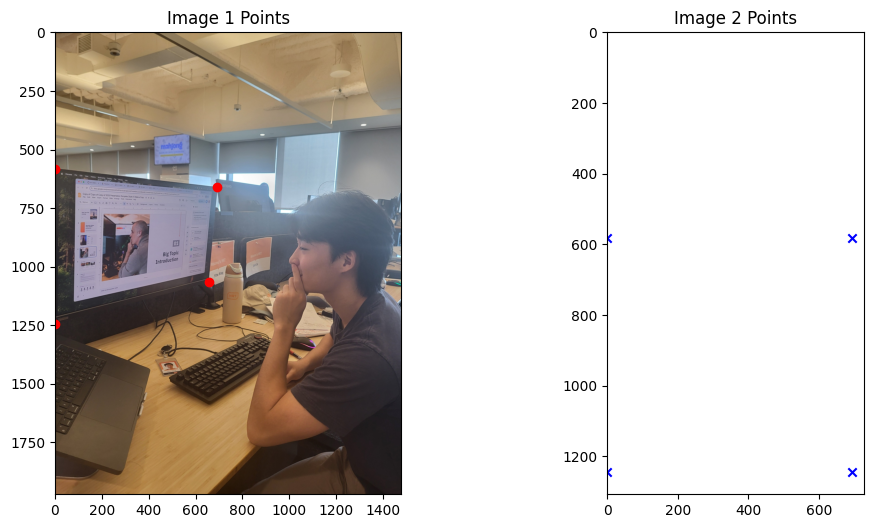

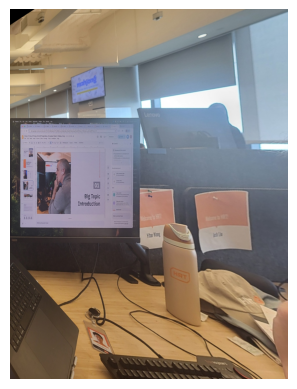

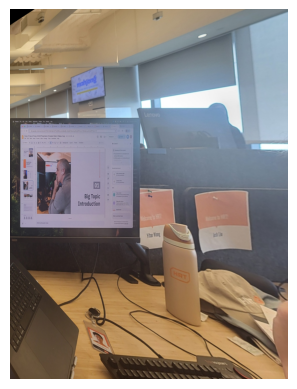

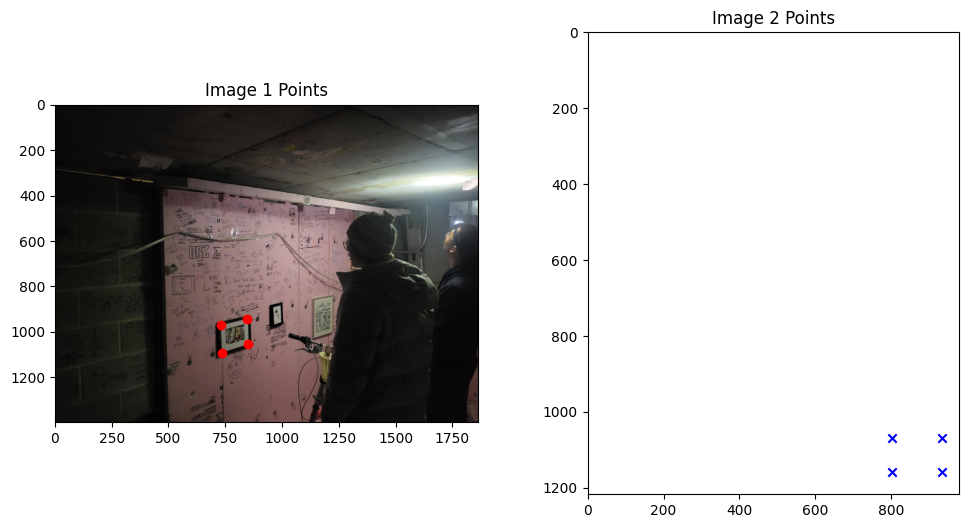

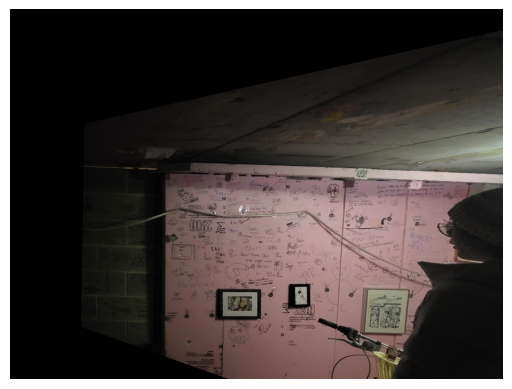

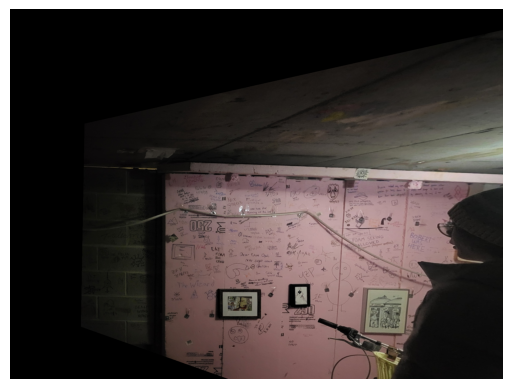

In [6]:
im = plt.imread("data/big_topic_intro.jpg")
im = np.rot90(im, k=-1)
print(im.shape)
im1_pts = np.array([[0, 1245], [0, 581], [692, 662], [656, 1067]])
im2_pts = np.round(np.array([[0, 1245], [0, 581], [692, 581], [692, 1245]]) * 1) 
visualize_correspondences(im, np.zeros((1,1,3)), im1_pts, im2_pts)
H = computeH(im1_pts, im2_pts)

warped_nn = warpImageNearestNeighbor(im, H)
show_image(warped_nn, "out/big_topic_intro_nn_warp.jpg")
warped_bilinear = warpImageBilinear(im, H)
show_image(warped_bilinear, "out/big_topic_intro_bilinear_warp.jpg")


im = plt.imread('data/foam_room.jpg')
im1_pts = np.array([[730, 971], [848, 942], [852, 1054], [734, 1091]])
im2_pts = np.round(np.array([[730, 971], [848, 971], [848, 1054], [730, 1054]]) * 1.1)
visualize_correspondences(im, np.zeros((1,1,3)), im1_pts, im2_pts)
H = computeH(im1_pts, im2_pts)
warped_nn = warpImageNearestNeighbor(im, H)
show_image(warped_nn, "out/foam_room_nn_warp.jpg")
warped_bilinear = warpImageBilinear(im, H)
show_image(warped_bilinear, "out/foam_room_bilinear_warp.jpg")

In [49]:
def mosaic(ims, pts_between_ims, reference_index=0):
    """
    Build a mosaic from a list of images 'ims' and a list of adjacent correspondences
    'pts_between_ims' where pts_between_ims[i] == (pts_i, pts_{i+1}) and
    computeH(pts_i, pts_{i+1}) returns a homography mapping coordinates in image i -> image i+1.

    Returns the stitched RGB (or grayscale) image with simple overwriting (keeps behavior close to original).
    """
    n = len(ims)
    assert len(pts_between_ims) == n - 1, "pts_between_ims must be length n-1 and correspond to adjacent pairs"

    # Hs[i] maps image i -> reference coordinates
    Hs = [np.eye(3) for _ in range(n)]
    for i in range(reference_index - 1, -1, -1):
        im_i_pts, im_ip1_pts = pts_between_ims[i]
        H_i_to_ip1 = computeH(np.array(im_i_pts), np.array(im_ip1_pts))
        Hs[i] = Hs[i + 1] @ H_i_to_ip1

    # Propagate right from reference (images with index > reference_index)
    for i in range(reference_index, n - 1):
        im_i_pts, im_ip1_pts = pts_between_ims[i]
        H_i_to_ip1 = computeH(np.array(im_i_pts), np.array(im_ip1_pts))
        Hs[i + 1] = Hs[i] @ np.linalg.inv(H_i_to_ip1)

    # Compute output canvas bounds
    corners = []
    for i, im in enumerate(ims):
        h, w = im.shape[:2]
        corner_pts = np.array([[0, 0, 1], [w - 1, 0, 1], [0, h - 1, 1], [w - 1, h - 1, 1]]).T  # pixel corners
        transformed = Hs[i] @ corner_pts
        transformed /= transformed[2, :]
        corners.append(transformed[:2, :])
    corners = np.hstack(corners)  # 2 x (4*n)
    min_xy = np.floor(corners.min(axis=1)).astype(int)
    max_xy = np.ceil(corners.max(axis=1)).astype(int)
    min_x, min_y = int(min_xy[0]), int(min_xy[1])
    max_x, max_y = int(max_xy[0]), int(max_xy[1])

    # +1 to include the last coordinate properly
    canvas_w = max_x - min_x + 1
    canvas_h = max_y - min_y + 1
    output_shape = (canvas_h, canvas_w, ims[0].shape[2]) if ims[0].ndim == 3 else (canvas_h, canvas_w)

    # Translation offset: maps reference coords -> canvas coords
    offset = np.array([[1, 0, -min_x],
                       [0, 1, -min_y],
                       [0, 0, 1]], dtype=np.float64)

    # Initialize canvas
    is_color = ims[0].ndim == 3
    out = np.zeros(output_shape, dtype=np.float64)
    # Track which pixels have content (binary mask)
    canvas_mask = np.zeros((canvas_h, canvas_w), dtype=bool)

    for i, im in enumerate(ims):
        h, w = im.shape[:2]
        H_canvas = offset @ Hs[i]
        
        # Create distance-based weight map that stays at 1.0 until near edges
        y_coords = np.arange(h)
        x_coords = np.arange(w)
        y_grid, x_grid = np.meshgrid(y_coords, x_coords, indexing='ij')
        
        # Distance to nearest edge (min of distances to all 4 edges)
        dist_to_edge = np.minimum(
            np.minimum(x_grid + 1, w - x_grid),
            np.minimum(y_grid + 1, h - y_grid)
        ).astype(np.float64)
        
        feather_width = 50  # pixels of falloff at edge
        alpha_map = np.clip(dist_to_edge / feather_width, 0, 1)
        
        # Warp the image
        warped = warpImageBilinear(im.astype(np.float64), H_canvas, 
                                   output_shape=output_shape[:2], fill=0)
        
        # Warp the alpha/weight map
        warped_alpha = warpImageBilinear(alpha_map, H_canvas, 
                                        output_shape=output_shape[:2], fill=0)
        
        # Create mask for current warped image (non-zero pixels)
        if is_color:
            warped_mask = (warped.sum(axis=2) > 0)
        else:
            warped_mask = (warped > 0)
        # Overlap region: where both canvas and new image have content
        overlap = canvas_mask & warped_mask
        # In overlap regions, use feathered alpha; elsewhere use full replacement
        effective_alpha = np.where(overlap, warped_alpha, 1.0)
        plt.imshow(effective_alpha, cmap='gray')
        plt.show()
        effective_alpha = effective_alpha[warped_mask]
        # Blend: where effective_alpha=1, fully replace; where <1, blend
        if is_color:
            for c in range(ims[0].shape[2]):
                out[warped_mask, c] = warped[warped_mask, c] * effective_alpha + out[warped_mask, c] * (1 - effective_alpha)
        else:
            out = warped * effective_alpha + out * (1 - effective_alpha)
        info = np.iinfo(ims[0].dtype)
        plt.imshow(np.clip(out, info.min, info.max).astype(ims[0].dtype), cmap='gray')
        plt.show()
        # Update canvas mask with new content
        canvas_mask |= warped_mask
    
    # Convert back to original dtype
    if np.issubdtype(ims[0].dtype, np.integer):
        info = np.iinfo(ims[0].dtype)
        out = np.clip(out, info.min, info.max).astype(ims[0].dtype)
    else:
        out = out.astype(ims[0].dtype)
    
    return out

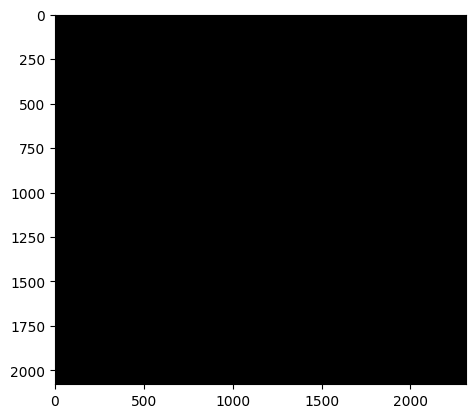

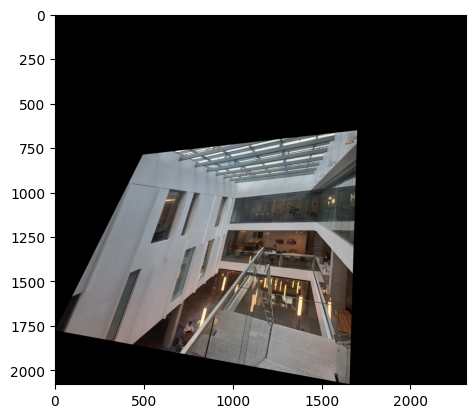

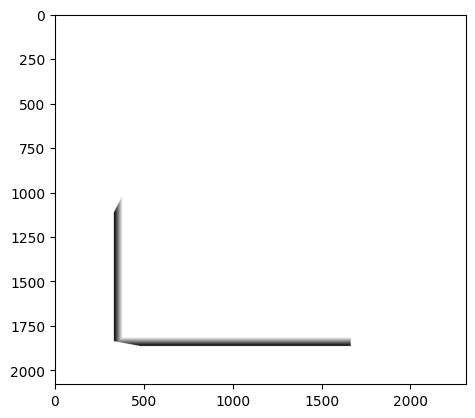

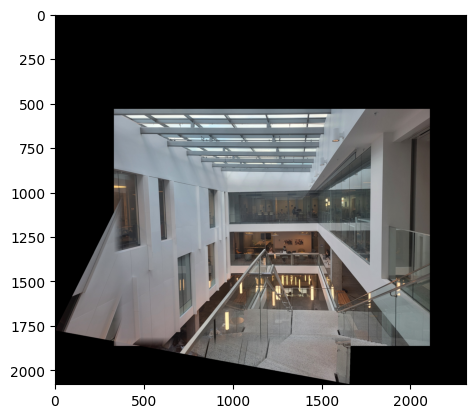

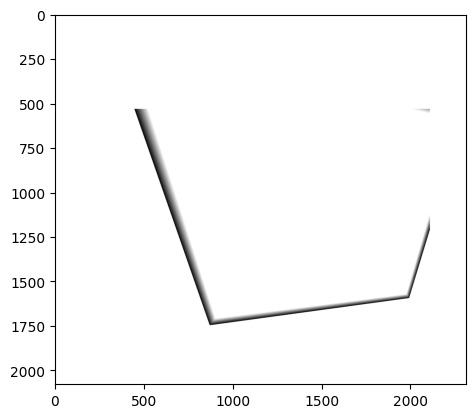

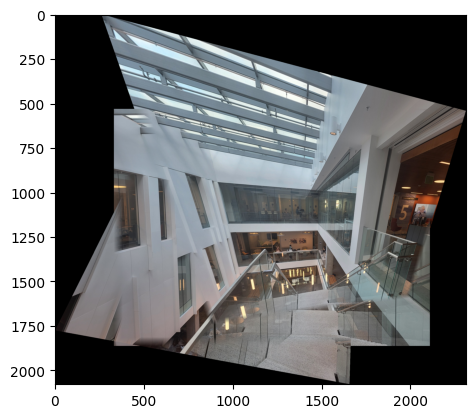

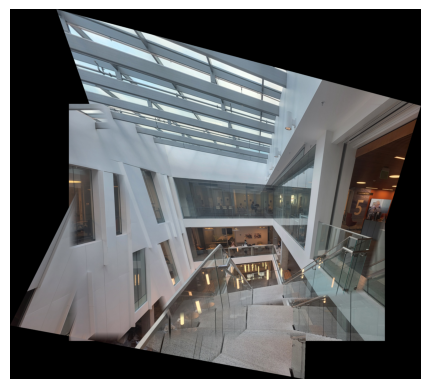

In [51]:
# Use bair51, bair52, bair53 images
im1 = plt.imread("data/bair53.jpg")
im2 = plt.imread("data/bair52.jpg")
im3 = plt.imread("data/bair51.jpg")
im_list = [im1, im2, im3]
# Read points from JSON files
with open("data/bair53_bair52.json") as f:
    data1 = json.load(f)
with open("data/bair52_bair51.json") as f:
    data2 = json.load(f)

pts_between_ims = [(data1["im1Points"], data1["im2Points"]), (data2["im1Points"], data2["im2Points"])]
m = mosaic(im_list, pts_between_ims, reference_index=1)
show_image(m, "out/bair5_mosaic.jpg")

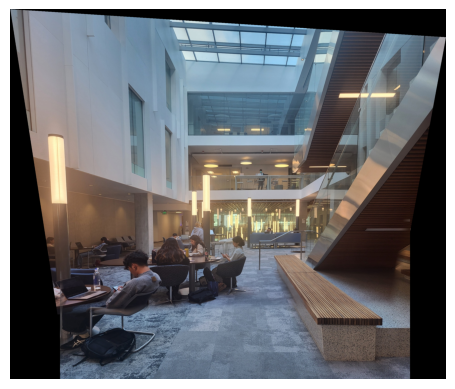

In [44]:
# Use bww31, bww32
im1 = plt.imread("data/bww31.jpg")
im2 = plt.imread("data/bww32.jpg")
im_list = [im1, im2]
# Read points from JSON file
with open("data/bww31_bww32.json") as f:
    data = json.load(f)
pts_between_ims = [(data["im1Points"], data["im2Points"])]
m = mosaic(im_list, pts_between_ims, reference_index=0)
show_image(m, "out/bww3_mosaic.jpg")

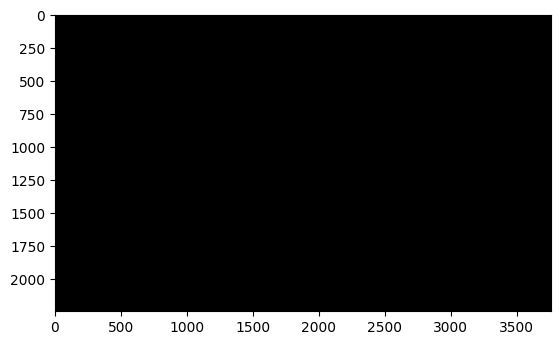

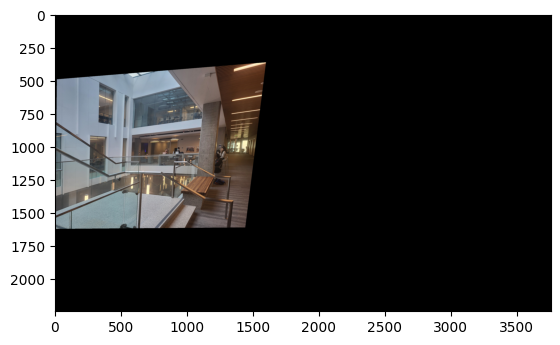

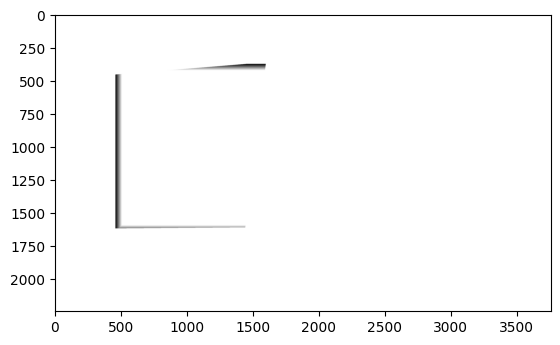

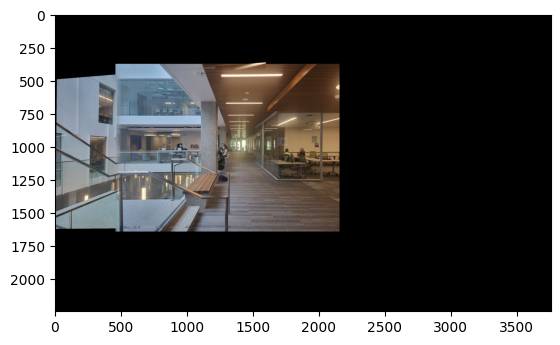

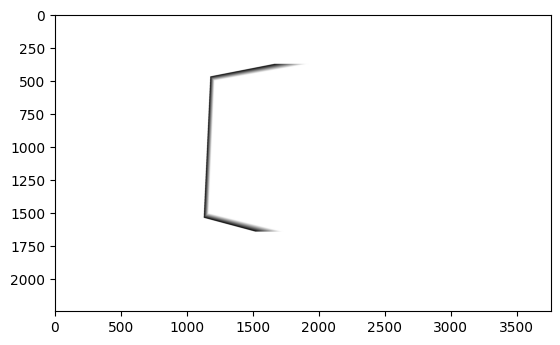

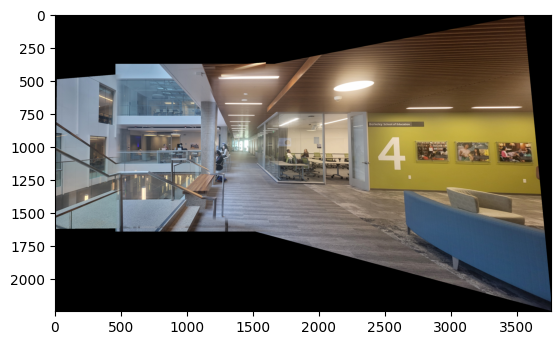

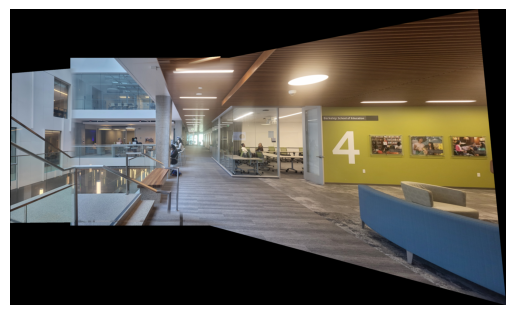

In [50]:
# Use bww41, bww42, bww43 images
im1 = plt.imread("data/bww41.jpg")
im2 = plt.imread("data/bww42.jpg")
im3 = plt.imread("data/bww43.jpg")
im_list = [im1, im2, im3]
# Read points from JSON files
with open("data/bww41_bww42.json") as f:
    data1 = json.load(f)
with open("data/bww42_bww43.json") as f:
    data2 = json.load(f)

pts_between_ims = [(data1["im1Points"], data1["im2Points"]), (data2["im1Points"], data2["im2Points"])]
m = mosaic(im_list, pts_between_ims, reference_index=1)
show_image(m, "out/bww4_mosaic.jpg")

In [11]:
# list all files in out/
import os
for filename in os.listdir("out/"):
    print(filename)

bair51.jpg
bair52.jpg
bair53.jpg
bair5_mosaic.jpg
bair5_mosaic_auto.jpg
big_topic_intro_bilinear_warp.jpg
big_topic_intro_nn_warp.jpg
big_topic_intro_prewarp.png
bww31.jpg
bww31_anms.png
bww31_bww32_matches.png
bww31_feature_descriptions.png
bww31_harris.png
bww32.jpg
bww3_mosaic.jpg
bww3_mosaic_auto.jpg
bww41.jpg
bww42.jpg
bww43.jpg
bww4_mosaic.jpg
bww4_mosaic_auto.jpg
correspondences.png
foam_room_bilinear_warp.jpg
foam_room_nn_warp.jpg
foam_room_prewarp.png
